## guide to openlca and ipc, how to automate openlca 

the aim of this example is to compute the environmental flows for 10 aluminium sandwich batches of 100 pieces each.
the data, which would usually be collected from several places and maybe compiled in a csv is in this case given and directly stored as dataframes.
using the dataframes, we will first do the basic environmental flow calculation without openlca.
afterwards, we're gonna set up units, flows, and processes in openlca through an ipc connection, and conduct the computation there.

some links:
- docs: https://greendelta.github.io/openLCA-ApiDoc/ipc/intro.html
- part of the docs all this is based on: https://greendelta.github.io/openLCA-ApiDoc/ipc/examples/pyipc_from_scratch.html
- the openlca ipc python package: https://pypi.org/project/olca-ipc/

### initial set up

**python**
in case you have never worked with python, there's abundant resources online, e.g. https://www.youtube.com/watch?v=rfscVS0vtbw .

**jupyter notebooks**
jupyter notebooks allows you to directly run the code within this tutorial and thus makes it easy to follow along. the setup is very easy and explained here: https://www.youtube.com/watch?v=WUeBzT43JyY
alternatively, you can just copy paste all the code from this tutorial into your own script and run it there.

**packages**
in terms of packages, all we need is pandas and olca-ipc. run the commands below in the terminal after installing python (or use your preferred package manager).

In [ ]:
!pip install olca-ipc
!pip install pandas

in addition, you will need to 

### doing stuff without openLCA

now we're gonna define the input and output d

In [21]:
import pandas as pd
import numpy as np

from typing import Callable

#### set up the basic process as a dataframe

define processes and their relations. the data is given in the example, and we're using panda dataframes.
these will also be used later on to set up things in openlca.

In [22]:
technosphere = pd.DataFrame(
    data=[
        [1.0, -50.0, -1.0, 0.0],
        [-0.01, 1.0, -1.0, 0.0],
        [0.0, 0.0, 1.0, -1.0],
        [0.0, 0.0, 0.0, 100],
    ],
    columns=[
        "electricity production",
        "aluminium production",
        "aluminium foil production",
        "sandwich package production",
    ],
    index=[
        "electricity [MJ]",
        "aluminium [kg]",
        "aluminium foil [kg]",
        "sandwich package [Item(s)]",
    ],
)

interventions = pd.DataFrame(
    data=[
        [0.0, -5.0, 0.0, 0.0],
        [-0.5, 0.0, 0.0, 0.0],
        [3.0, 0.0, 0.0, 0.0],
        [2.0, 10.0, 0.0, 1.0],
    ],
    columns=technosphere.columns,
    index=[
        "bauxite [kg]",
        "crude oil [kg]",
        "CO2 [kg]",
        "solid waste [kg]",
    ],
)

print(technosphere)
print(interventions)

                            electricity production  aluminium production  \
electricity [MJ]                              1.00                 -50.0   
aluminium [kg]                               -0.01                   1.0   
aluminium foil [kg]                           0.00                   0.0   
sandwich package [Item(s)]                    0.00                   0.0   

                            aluminium foil production  \
electricity [MJ]                                 -1.0   
aluminium [kg]                                   -1.0   
aluminium foil [kg]                               1.0   
sandwich package [Item(s)]                        0.0   

                            sandwich package production  
electricity [MJ]                                    0.0  
aluminium [kg]                                      0.0  
aluminium foil [kg]                                -1.0  
sandwich package [Item(s)]                        100.0  
                  electricity production  a

#### compute elemental flows

now we do the computation of the elemental flows for a functional unit of 10 sandwich packages using some matrix math.

In [23]:
f = [
    0.0,
    0.0,
    0.0,
    10,
]
s = np.linalg.solve(technosphere.to_numpy(), f)
g = interventions.to_numpy() @ s
print(pd.DataFrame(g, index=interventions.index))


                      0
bauxite [kg]      -1.01
crude oil [kg]    -5.10
CO2 [kg]          30.60
solid waste [kg]  22.52


### doing the same with openlca through ipc, starting from an empty db

#### set up stuff in openlca

start openlca
create new *empty* database called 'ipc_from_scratch'
go to tools > developer tools > ipc server
click run (keep default port 8080) and allow as admin

#### connect to ipc of running local openlca 

In [24]:
import olca_ipc as ipc
import olca_schema as o

client = ipc.Client(8080)


#### set up new units and flow properties in the empty db

create new units with `new_unit_group('name', 'short')`
create new flow properties with `new_flow_property('name', unit)`

shove it into the empty db using `client.put_all(...)`

In [26]:
mass_units = o.new_unit_group("Mass units", "kg")
energy_units = o.new_unit_group("Energy units", "MJ")
counting_units = o.new_unit_group("Counting units", "Item(s)")
mass = o.new_flow_property("Mass", mass_units)
energy = o.new_flow_property("Energy", energy_units)
count = o.new_flow_property("Number of items", counting_units)

client.put_all(
    mass_units,
    energy_units,
    counting_units,
    mass,
    energy,
    count,
)

verify it worked by refreshing the navigator

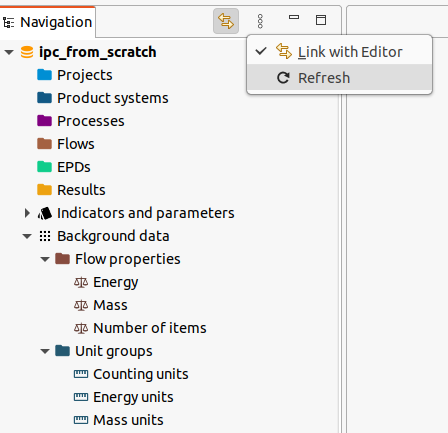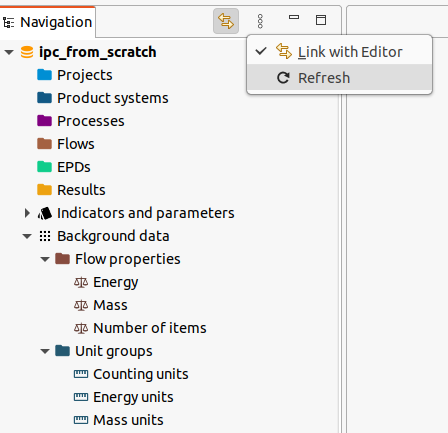

usually you'll use existing flowproperties, which can be retrieved from any *real* db using **client.get(what, filter)**

In [16]:
print(client.get(o.FlowProperty, name="Mass").to_json())


{
  "@type": "FlowProperty",
  "@id": "53572e75-d680-4c0c-9159-11c21ae75820",
  "lastChange": "2024-02-22T12:59:54.681Z",
  "name": "Mass",
  "unitGroup": {
    "@type": "UnitGroup",
    "@id": "33f623ba-12f3-4740-a41a-4b1ecd2515c9",
    "name": "Mass units"
  },
  "version": "01.00.000"
}


#### create the actual flows

using a custom function called `create_flow(rowlabel, callable)`, which takes the individual entry and turns it into a new product or elementary flow (as in the usual openlca definitions).

> sidenote: a callable is a datatype refering to sth that can be called. further definitions can be given, e.g. when used as argument like it is here. callable[[arguments],[returnvalues]] where arguments and returnvalues can be specified as specific datatypes

then we iterate over teh technosphere and intervention (environmental flows) and turn them into actual flows using the new function


In [17]:
from typing import Callable

def create_flow(
    row_label: str, fn: Callable[[str, o.FlowProperty], o.Flow]
) -> o.Flow:
    parts = row_label.split("[")
    name = parts[0].strip()
    unit = parts[1][0:-1].strip()
    match unit:
        case "kg":
            prop = mass
        case "MJ":
            prop = energy
        case "Item(s)":
            prop = count
    flow = fn(name, prop)
    client.put(flow)
    return flow


tech_flows = [create_flow(label, o.new_product) for label in technosphere.index]
envi_flows = [
    create_flow(label, o.new_elementary_flow) for label in interventions.index
]


#### create the actual processes thru code

set up the new processes in openlca through the ipc using

- `new_process(name)`                         to set it up
- `new_input(process, flow, value)`           create a new input for the defined process with a defined amount (value) of a defined flow  
- `new_output(process, flow, value)`          create a new output for the defined process with a defined amount (value) of a defined flow  
- `custom function: exchange(flow, float)`    to sort the inputs and outputs, stored in a single dataframe and distinguished by sign into inputs and outputs and actually add them to the new process

create a new process (for now just a variable, no in the openlca instance)
iterate over the dataframes, call exchange for all entries and set them as is_quantitative_reference if their index in the dataframe is the same as the current iteration step
do this for both techno & biosphere
add the finished process to the local openlca instance using client.put(process)

In [18]:
def create_process(index: int, name: str) -> o.Process:
    process = o.new_process(name)

    def exchange(flow: o.Flow, value: float) -> o.Exchange | None:
        if value == 0:
            return None
        if value < 0:
            return o.new_input(process, flow, abs(value))
        else:
            return o.new_output(process, flow, value)

    for (i, tech_flow) in enumerate(tech_flows):
        value = technosphere.iat[i, index]
        e = exchange(tech_flow, value)
        if e and i == index:
            e.is_quantitative_reference = True

    for (i, envi_flow) in enumerate(envi_flows):
        value = interventions.iat[i, index]
        exchange(envi_flow, value)

    client.put(process)
    return process


processes = [
    create_process(index, name)
    for (index, name) in enumerate(technosphere.columns)
]

### next up we calculate the inventory (so all environmental flows, no products)

prep the calculation using `CalculationSetup(target, unit, amount)`
target specifies what should be calculated.
the correct object can be retrieved through `o.Ref(ref_type, id)` by providing the o.RefType.Process and the id of the sandwich making process, which we stored in the list above.
unit is set to item count
amount is given as 10. fyi, the functional unit variable `f` we used to calculate stuff above was not used in computing the inputs, so this is not redundant

then we actually conduct the calculation using `client.calculate(setup)` and wait til it's done.

In [19]:
setup = o.CalculationSetup(
    target=o.Ref(ref_type=o.RefType.Process, id=processes[3].id),
    unit=count.unit_group.ref_unit,  # "Item(s)"
    amount=10,
)
result = client.calculate(setup)
result.wait_until_ready()

ResultState(id='1c8db550-d130-4600-bc98-f8a143c82668', error=None, is_ready=True, is_scheduled=False, time=1708606810059)

### now to check for the result of the computation

check the results and print them prettily

In [20]:
inventory = result.get_total_flows()
print(
    pd.DataFrame(
        data=[
            (
                i.envi_flow.flow.name,
                i.envi_flow.is_input,
                i.amount,
                i.envi_flow.flow.ref_unit,
            )
            for i in inventory
        ],
        columns=["Flow", "Is input?", "Amount", "Unit"],
    )
)

          Flow  Is input?  Amount Unit
0    crude oil       True    5.10   kg
1          CO2      False   30.60   kg
2  solid waste      False   22.52   kg
3      bauxite       True    1.01   kg


### yay we done

delete the results and wipe the client to clean up.

In [ ]:
result.dispose()
client = None

> sidenote: if you wanna check what you can do with the client and ipc in general, you can check out the repo: https://github.com/GreenDelta/olca-ipc.py/blob/master/olca_ipc/ipc.py

## part 2 - impact assessment boogaloo

this is not part of the original tutorial, but also relevant.
the aim is to learn to work with an actual database and conduct an impact assessment for an existing process.
we won't set up a new process, as it essentially works the same it did in the empty db.

for this, we need to actually use a real database (and not an empty one)
switch to the openlca window, and close the ipc connection.
then, open another database, ideally a newly downloaded one as we don't want to mess up existing work nexus.openlca.org/downloads
again, go to tools > developer tools > ipc server and start it on port 8080.



In [ ]:
import pprint as pp              #just for pretty prints
client = ipc.Client(8080)

### getting a process

first we get an overview of how many there are.
use `get_descriptor()` instead of `get_all()` as the latter might crash the server for large databases.
the info we get through `get_descriptor()` is limited to a few basic properties.  

In [ ]:
processDescriptors = pd.DataFrame(client.get_descriptors(o.Process))

print(f'Number of processes: {len(processDescriptors.index)}')
print(f'Available data: {", ".join(processDescriptors.columns)}')

to actually get a process, we have to know its ID or name (the latter might return multiple).
we're gonna start by getting the id of the process through the descriptor list, and then actually querying for the entire entry.
take a look at the process data and structure.

In [ ]:
testProcessID = processDescriptors.id[0]
testProcess = client.get(o.Process, testProcessID)   #use the same function but with a string to search by name
pp.pprint(testProcess)

#### creating a product system

in a next step, we'll turn the process into a product system.
this is necessary to conduct an impact assessment.

In [ ]:
processRef = client.find(o.Process, testProcess.name)
config = o.LinkingConfig(
    prefer_unit_processes=True,
    provider_linking=o.ProviderLinking.PREFER_DEFAULTS,
)
productSystemRef = client.create_product_system(process_ref, config)
print(f"created product system {system_ref.name}, id={system_ref.id}")

### conducting the impact assessment

now let's check which assessment methods are available.

In [ ]:
methods = client.get_descriptors(o.ImpactMethod)
for method in methods:
    print(f"{method.name} :: {method.id}")

hopefully you got a nice list.
again, to keep it simple, we're gonna use the first one and apply it to our process using the calculate setup

In [ ]:
method = methods[0] if methods else print("no  methods found. check your database")
setup = o.CalculationSetup(
    target=o.Ref(
        ref_type=o.RefType.ProductSystem,
        id=productSystemRef.id,
    ),
    impact_method=o.Ref(id=method.id),
)
result = client.calculate(setup)
result.wait_until_ready()

Now we just need to get the actual impact category values and make them look neat.

In [ ]:
impactResults = result.get_total_impacts()

prettyResults = pd.DataFrame(
    data=[(
            impactValue.impact_category.name,
            impactValue.amount,
            impactValue.impact_category.ref_unit            
        )
        for impactValue in impactResults
    ],
    columns=["impact category", "amount", "unit"],
)

prettyResults.sort_values(by=['impact category'])


## yay all done